<a href="https://colab.research.google.com/github/arpitamangal/text-to-image-generation/blob/main/TextToImageStableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [ ]:
!pip install keras-cv==0.4.0 -q
!pip install -U tensorflow -q
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.9 MB/s eta 0:00:00


In [ ]:
from textwrap import wrap
import os
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras

### Tranforming Data as per pre-trained model

In [ ]:
from datasets import load_dataset

dataset = load_dataset("pranked03/flowers-blip-captions")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6552 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/pranked03___parquet/pranked03--flowers-blip-captions-b982889d357441ec/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 6552
    })
})

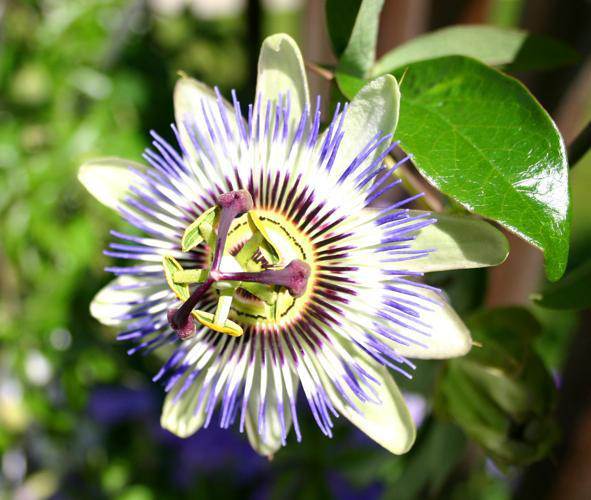

In [ ]:
dataset["train"][0]["image"]

In [ ]:
dataset["train"][0]["text"]

'a close up of a passion flower'

In [ ]:
!mkdir "flower_dataset"

In [ ]:
image_paths = []
captions = []
idx = 0

for image, caption in zip(dataset["train"]["image"], dataset["train"]["text"]):
    image_name = "image_" + str(idx) + ".png"
    image_path = os.path.join("flower_dataset", image_name)
    image.save(image_path)

    image_paths.append(image_name)
    captions.append(caption)

    idx += 1

In [ ]:
dataframe = pd.DataFrame({
    "image_path": image_paths,
    "caption": captions
})
dataframe.to_csv("flower_dataset/data.csv", index=False)

In [ ]:
dataframe.head()

,image_path,caption
0,image_0.png,a close up of a passion flower
1,image_1.png,a blue passion flower with a yellow flower in ...
2,image_2.png,a purple passion flower in a pot
3,image_3.png,a purple passion flower with white flowers and...
4,image_4.png,a passion flower in the garden


In [ ]:
dataframe.shape

(6552, 2)

In [ ]:
!tar cf flower_dataset.tar.gz flower_dataset

In [ ]:
!cp flower_dataset.tar.gz /content/drive/MyDrive

#### Saved the data on hugging face and importing it from there

In [ ]:
data_path = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/arpitamangal/flower-blip-original-version/resolve/main/flower_dataset.tar.gz",
    untar=True,
)

print("data_path: ", data_path)

data_frame = pd.read_csv(os.path.join(data_path, "data.csv"))
#data_frame = data_frame1.head(2)

data_frame["image_path"] = data_frame["image_path"].apply(
    lambda x: os.path.join(data_path, x)
)
data_frame.head()

2646282240/2646282240 [==============================] - 24s 0us/step
data_path:  /root/.keras/datasets/flower_dataset


,image_path,caption
0,/root/.keras/datasets/flower_dataset/image_0.png,a close up of a passion flower
1,/root/.keras/datasets/flower_dataset/image_1.png,a blue passion flower with a yellow flower in ...
2,/root/.keras/datasets/flower_dataset/image_2.png,a purple passion flower in a pot
3,/root/.keras/datasets/flower_dataset/image_3.png,a purple passion flower with white flowers and...
4,/root/.keras/datasets/flower_dataset/image_4.png,a passion flower in the garden


In [ ]:
len(data_frame)

6552

### Tokenising the captions

In [ ]:
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

1356917/1356917 [==============================] - 0s 0us/step


### Building input data pipeline in tensorflow

In [ ]:
## Lowering the resolution from the orginial diffusion model (512) due to memory issue
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

492466864/492466864 [==============================] - 7s 0us/step


In [ ]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data_frame["image_path"]), tokenized_texts, batch_size=4
)

# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)

images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


### Training

In [ ]:
class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Convert images to latent space
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            target = noise

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )


In [ ]:
image_encoder = ImageEncoder(RESOLUTION, RESOLUTION)
diffusion_ft_trainer = Trainer(
    diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=False,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://huggingface.co/docs/diffusers/training/text2image
lr = 1e-5
beta_1 = 0.9
beta_2 = 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")

3439090152/3439090152 [==============================] - 35s 0us/step


In [ ]:
epochs = 10
ckpt_path = "finetuned_stable_diffusion.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])

Instructions for updating:
Use fn_output_signature instead


1638/1638 [==============================] - 917s 387ms/step - loss: 0.1422


### Export weights

In [ ]:
# weights = diffusion_ft_trainer.get_weights()
# import h5py
# diffusion_ft_trainer.save_weights("/content/drive/MyDrive/weights.h5")

In [ ]:
# img_height = img_width = 512
# flower_model = keras_cv.models.StableDiffusion(
#     img_width=img_width, img_height=img_height
# )
# # We just reload the weights of the fine-tuned diffusion model.
# flower_model.diffusion_model.load_weights("/content/drive/MyDrive/weights.h5")

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


### Generate Images

In [ ]:
weights_path = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/arpitamangal/flower-blip-weights/resolve/main/flower-weights.h5"
)
img_height = img_width = 512
flower_model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)
flower_model.diffusion_model.load_weights(weights_path)

25/25 [==============================] - 7s 289ms/step


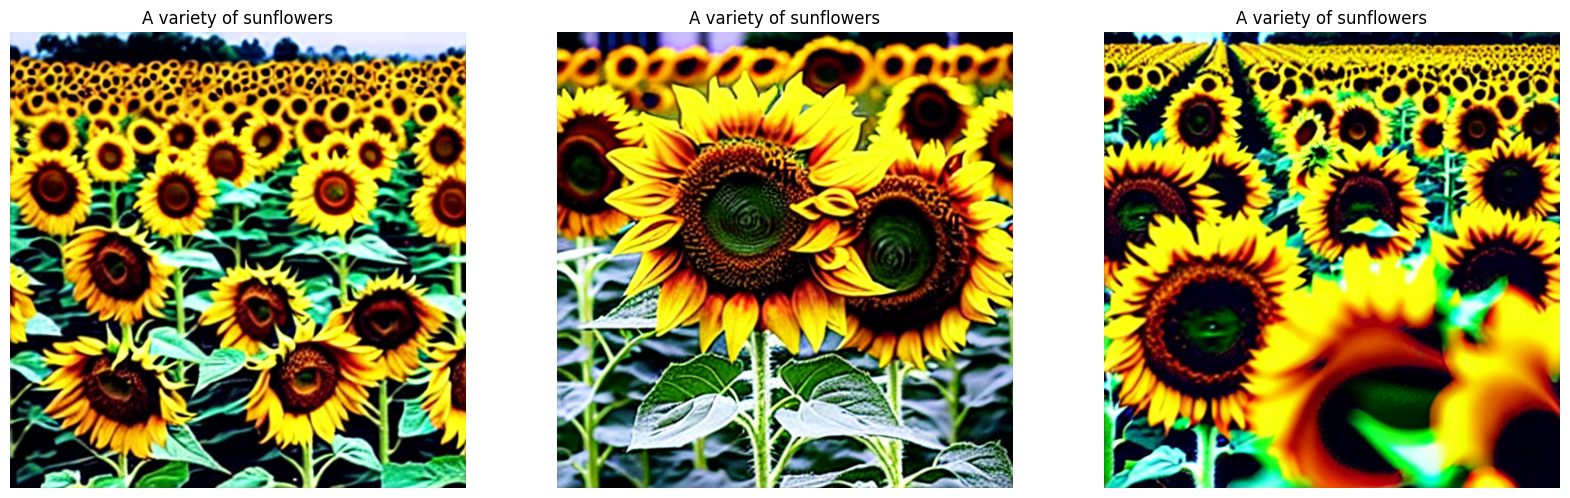

In [ ]:
def plot_images(images, title):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title, fontsize=12)
        plt.axis("off")

prompt = "A variety of sunflowers"
variations_of_image = 3
generated_image = flower_model.text_to_image(prompt, batch_size=variations_of_image, unconditional_guidance_scale=40)
plot_images(generated_image, prompt)